In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import transformers
import json
from pathlib import Path
import torch
from transformers import BertForQuestionAnswering
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm.auto import tqdm
print("pakages imported")

pakages imported


MyBertSelfAttention_detect

In [3]:
from torch import nn
from transformers.models.albert.modeling_albert import AlbertLayerGroup
from transformers.modeling_outputs import BaseModelOutput

INIT_MAG = 1.6e-1
MAX_NORM = 1000

class MyAlbertTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.embedding_hidden_mapping_in = nn.Linear(config.embedding_size, config.hidden_size)
        self.albert_layer_groups = nn.ModuleList([AlbertLayerGroup(config) for _ in range(config.num_hidden_groups)])
        self.perturb = None
        
    #modified
    
    def p_init(self, input_length):
        SQRT_NUMEL = (input_length * self.config.hidden_size) ** 0.5
        self.perturb = torch.zeros((1, input_length, self.config.hidden_size), device = torch.device('cuda')).uniform_(-INIT_MAG, INIT_MAG)/SQRT_NUMEL
        self.perturb.requires_grad_()
        
    def p_accu(self, loss, adv_lr, input_length = 5):
        grad = torch.autograd.grad(loss, self.perturb)[0]
        grad = (adv_lr * grad/grad.norm()).detach()
        
        grad[:, 0, :] = 0.0
        grad[:, -1, :] = 0.0
        
        self.perturb = (self.perturb + grad).detach()
        n = self.perturb.norm()
        if n > MAX_NORM:
            self.perturb = (MAX_NORM * self.perturb/n).detach()
        self.perturb.grad = None
        self.perturb.requires_grad_()
        
    def set_pos(self, pos):
        self.perturb_pos = pos
    ##here
    
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        
        hidden_states = self.embedding_hidden_mapping_in(hidden_states)

        all_hidden_states = (hidden_states,) if output_hidden_states else None
        all_attentions = () if output_attentions else None

        for i in range(self.config.num_hidden_layers):
            # Number of layers in a hidden group
            if i == self.perturb_pos and self.perturb is not None:
                hidden_states = hidden_states + self.perturb
            layers_per_group = int(self.config.num_hidden_layers / self.config.num_hidden_groups)

            # Index of the hidden group
            group_idx = int(i / (self.config.num_hidden_layers / self.config.num_hidden_groups))

            layer_group_output = self.albert_layer_groups[group_idx](
                hidden_states,
                attention_mask,
                head_mask[group_idx * layers_per_group : (group_idx + 1) * layers_per_group],
                output_attentions,
                output_hidden_states,
            )
            hidden_states = layer_group_output[0]

            if output_attentions:
                all_attentions = all_attentions + layer_group_output[-1]

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=all_hidden_states, attentions=all_attentions
        )

In [4]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]
task = 'sst2'
model_checkpoint = "albert-base-v2"
model_state = None

In [5]:
from datasets import load_dataset, load_metric
import datasets

from transformers import AlbertForSequenceClassification
import math

actual_task = "mnli" if task == "mnli-mm" else task
num_labels = 3 if task.startswith("mnli") else 1 if task=="stsb" else 2
dataset = datasets.DatasetDict.load_from_disk("glue/" + actual_task)

task_to_keys = {    
                "cola": ("sentence", None),
                "mnli": ("premise", "hypothesis"),
                "mnli-mm": ("premise", "hypothesis"),
                "mrpc": ("sentence1", "sentence2"),
                "qnli": ("question", "sentence"),
                "qqp": ("question1", "question2"),
                "rte": ("sentence1", "sentence2"),
                "sst2": ("sentence", None),
                "stsb": ("sentence1", "sentence2"),
                "wnli": ("sentence1", "sentence2"),
            }

sentence1_key, sentence2_key = task_to_keys[task]


from transformers import AutoTokenizer,RobertaForSequenceClassification, AutoModelForSequenceClassification
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

def preprocess_function(examples):
    if sentence2_key is None:
        return tokenizer(examples[sentence1_key], truncation=True)
    return tokenizer(examples[sentence1_key], examples[sentence2_key], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format("numpy")

In [6]:
from transformers import AutoTokenizer,AlbertForSequenceClassification, AutoModelForSequenceClassification
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
encoded_dataset = dataset.map(preprocess_function, batched=True, keep_in_memory = True)


model = AlbertForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels, mirror = "bfsu")
torch.save(model.state_dict(),"albert_raw_pretrained_state.pth")

model.albert.encoder = MyAlbertTransformer(model.config)
    
model.load_state_dict(torch.load("SST2-fullfinetuned-albert-8848.pth"))
encoded_dataset.set_format("numpy")

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

In [7]:
from transformers import AutoModelForMaskedLM, AutoTokenizer,AlbertForMaskedLM


model_mlm = AlbertForMaskedLM.from_pretrained(model_checkpoint)
probe_layer = model_mlm.predictions

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast = True)

In [8]:
victim_model = AlbertForSequenceClassification(model.config)
victim_model.load_state_dict(torch.load("SST2-fullfinetuned-albert-8848.pth"))
victim_model.cuda()

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768,

In [9]:
import tensorflow_hub as hub
import tensorflow as tf
class USE:
    def __init__(self):
        self.embed = hub.load("use")

    def count_use(self, sentence1, sentence2):
        embeddings = self.embed([sentence1, sentence2])

        vector1 = tf.reshape(embeddings[0], [512, 1])
        vector2 = tf.reshape(embeddings[1], [512, 1])

        return tf.matmul(vector1, vector2, transpose_a=True).numpy()[0][0]
use = USE()

In [10]:
tokenizer.convert_ids_to_tokens([0,1,2,3,4])

['<pad>', '<unk>', '[CLS]', '[SEP]', '[MASK]']

In [11]:
from torch.nn import CrossEntropyLoss, MSELoss
class Prober():
    
    def __init__(self, tokenizer, probe_layer, victim_model):
        self.celoss = CrossEntropyLoss()
        self.tokenizer = tokenizer
        self.probe_layer = probe_layer
        self.victim = victim_model
        
        if torch.cuda.is_available():
            self.probe_layer.cuda()
            
    def decode(self, hidden, origin_ids = None):
        probe = self.probe_layer(hidden)
        
        _probe = probe.detach()
        _probe[:, :,0:5] = 0.0
        #mask token
        
        
        reconstruction_ids = torch.topk(_probe, 1, -1)[1].squeeze(-1)
        
        reconstruction_ids[:, 0] = 2
        reconstruction_ids[:,-1] = 3
        
        if origin_ids is None:
            return reconstruction_ids
        
        origin_ids = origin_ids[:, 1:-1].long().cuda()
        probe = probe[:, 1:-1, :]

        
        decode_loss = self.celoss(probe.reshape(-1, tokenizer.vocab_size), origin_ids.reshape(-1))

        return decode_loss, reconstruction_ids
        
    
    def attack(self, ids, answer_label):
        
        ids = ids.unsqueeze(0).cuda()
        attention_mask = (torch.zeros(ids.shape) + 1).long().cuda()
        answer_label = answer_label.cuda()
        
        output = self.victim(input_ids = ids, attention_mask = attention_mask, labels = answer_label)
        logits = output[1]

        adv_answer = logits.argmax(dim = 1)
        
        ids = ids[:, 1:-1]
        reconstruction_tokens = self.tokenizer.batch_decode(ids)
        reconstruction_sentence = self.tokenizer.convert_tokens_to_string(reconstruction_tokens)
#         print(reconstruction_sentence)

#         print(adv_answer,answer_label, "LOGITS: ", logits )
        reconstruction_sentence = None
        
        
        if not adv_answer.equal(answer_label):
            #print("CALL")
            reconstruction_tokens = self.tokenizer.batch_decode(ids)
            reconstruction_sentence = self.tokenizer.convert_tokens_to_string(reconstruction_tokens)
            
        return reconstruction_sentence
    
prober = Prober(tokenizer, probe_layer, victim_model)

In [12]:
from tqdm import tqdm

def cal_metric(s1, s2):
    _use = use.count_use(s1,s2)
    return _use,0,0

def attack_step(dataset = None, encoded_dataset = None, index = 0, 
                adv_lr = 3e-2, adv_steps = 3, start_layer = 0, prober = None, 
                scheduler = None, SEED = 114514):
    
    encoded_dataset.set_format("numpy")
    
    def model_forward(model, input_ids, attention_mask, labels):
        output = model(input_ids=input_ids, attention_mask=attention_mask, labels = labels, output_hidden_states = True)
        loss = output[0]
        hidden = output[2][HIDDEN_INDEX]
        logits = output[1]
        return loss,logits,hidden
    
    def random_cover(ids):
        import random 
        rindex = random.randint(1, input_length- 2)
        ids[:, rindex] = 4
        return ids
    
    

    ori_sentence = dataset['validation'][index]['sentence']
    ori_input_ids = torch.tensor(encoded_dataset['validation']['input_ids'][index]).unsqueeze(0).cuda()

    attention_mask = torch.tensor(encoded_dataset['validation']['attention_mask'][index]).unsqueeze(0).cuda()
    label = torch.tensor(encoded_dataset['validation']['label'][index]).unsqueeze(0).cuda()
    
    #print("LABEL", label)
    correct_test = prober.attack(ori_input_ids[0], label)
    #print(correct_test)
    if correct_test is not None:
        return None
    
    #BATCH SET UP
    input_length = len(ori_input_ids[0])
    input_ids = random_cover(ori_input_ids.clone())
    
    
    p_layer = model.albert.encoder
    p_layer.set_pos(start_layer)
    p_layer.perturb = None
    
        
    
    successed = False
    query = 0
    pll = 0
    I = 0
    use = 0
    bpstep = 0
    rec_token_acc = 0
    adv_sentence = None
    
    id_base = []
    id_base.append(input_ids.tolist())

    torch.manual_seed(SEED)
    origin_loss, origin_logits, origin_hidden = model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = label)
    reconstruct_ids = prober.decode(origin_hidden)

    rec_token_acc = ((input_ids == reconstruct_ids).sum() / input_ids.numel()).tolist()
    
    for i in reconstruct_ids:
        if not i.tolist() in id_base:
            id_base.append(i.tolist())
            query += 1
            adv_sentence = prober.attack(i, label)
            if adv_sentence is not None:
                use,I,ppl = cal_metric(ori_sentence, adv_sentence)
                #print("USE = ", use)
                if use > USE_GATE:
                    successed = True
                    bpstep = -1
                    successed = True
                    return{
                        'successed': successed,
                        'query': query,
                        'pll': pll,
                        'I': I,
                        'use': use,
                        'bpstep': bpstep,
                        'token_acc': rec_token_acc,
                        'ori_sentence': ori_sentence,
                        'adv_sentence': adv_sentence
                    }

    torch.manual_seed(SEED)
    p_layer.p_init(input_length)
    torch.manual_seed(SEED)
    loss, logits, hidden = model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = label)
    decode_loss, init_ids = prober.decode(hidden, origin_ids = input_ids)
    
    for i in init_ids:
        if not i.tolist() in id_base:
            id_base.append(i.tolist())
            query += 1
            adv_sentence = prober.attack(i, label)
            if adv_sentence is not None:
                use,I,ppl = cal_metric(ori_sentence, adv_sentence)
                if use > USE_GATE:
                    successed = True
                    bpstep = -1
                    successed = True
                    return{
                        'successed': successed,
                        'query': query,
                        'pll': pll,
                        'I': I,
                        'use': use,
                        'bpstep': bpstep,
                        'token_acc': rec_token_acc,
                        'ori_sentence': ori_sentence,
                        'adv_sentence': adv_sentence
                    }



    seg_step = 0
    max_use = 0
    
    for seg_step in range(SEG_STEP):
        lr = adv_lr
        for i in (range(adv_steps)):

            projected = p_layer.p_accu(loss * LOSS_WEIGHT - decode_loss * DECODE_WEIGHT, lr, input_length = input_length)

            torch.manual_seed(SEED)
            loss, logits, hidden =  model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = label)
            decode_loss, p_ids = prober.decode(hidden, origin_ids = input_ids)

            for p_id in p_ids:
                if not p_id.tolist() in id_base:
                    id_base.append(p_id.tolist())
                    query += 1
                    adv_sentence = prober.attack(p_id, label)

                    if adv_sentence is not None:
                        use,I,ppl = cal_metric(ori_sentence, adv_sentence)
#                         print(adv_sentence, " USE = ",use)
                        if use> max_use:
                            max_use = use
                        if use > USE_GATE:
                            successed = True
                            bpstep = seg_step * adv_steps + i
                            successed = True
                            return{
                                'successed': successed,
                                'query': query,
                                'pll': pll,
                                'I': I,
                                'use': use,
                                'bpstep': bpstep,
                                'token_acc': rec_token_acc,
                                'ori_sentence': ori_sentence,
                                'adv_sentence': adv_sentence
                            }
#         print("################RESET!####################", " D_LOSS = ", (loss-origin_loss).norm(), "BASED: ", len(id_base), "Query; ", query)
        input_ids = random_cover(ori_input_ids.clone())
#         print(input_ids.tolist())
        torch.manual_seed(SEED + seg_step)
        p_layer.p_init(input_length)
        loss, logits, hidden = model_forward(model, input_ids=input_ids, attention_mask=attention_mask, labels = label)
    torch.cuda.empty_cache()
    return{
        'successed': successed,
        'query': query,
        'pll': pll,
        'I': I,
        'use': max_use,
        'bpstep': bpstep,
        'token_acc': rec_token_acc,
        'ori_sentence': ori_sentence,
        'adv_sentence': adv_sentence
    }


In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
model.cuda()
import seaborn as sb
import gc

gc.collect()
torch.cuda.empty_cache()
SEG_STEP = 10

HIDDEN_INDEX = 11
INIT_MAG = 1

BATCH_SIZE = 1
USE_GATE = 0.87

SEED = 114514


LOSS_WEIGHT = 1
DECODE_WEIGHT = 0.01


def exp_lr(adv_lr, step):
    if step > 200:
        adv_lr -= 1/400
    return adv_lr

suca = []
alla = []
import random
random.seed(SEED)
for i in tqdm(range(696,701)):
    gc.collect()
    torch.cuda.empty_cache()
    ret = attack_step(
        dataset = dataset, 
        encoded_dataset = encoded_dataset, 
        index = i, 
        adv_lr = 7,
        adv_steps = 100, 
        start_layer = 0, 
        prober = prober,
        scheduler = None,
        SEED = SEED
        )
#     print(ret)
    if ret is not None:
        if ret['successed']:
            suca.append(ret)
        alla.append(ret)
    if i%5 ==0:
        torch.save(alla, "albert_alla_696_" + str(i) + ".pt")

  0%|          | 0/5 [00:00<?, ?it/s]/mistgpu/site-packages/datasets/formatting/formatting.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(array, copy=False, **self.np_array_kwargs)
100%|██████████| 5/5 [00:47<00:00,  9.44s/it]


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


{'successed': 1.0, 'query': 95.0, 'pll': 0.0, 'I': 0.0, 'use': 0.9059271, 'bpstep': 113.0, 'token_acc': 0.7719298601150513}


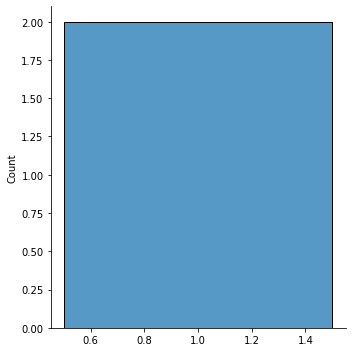

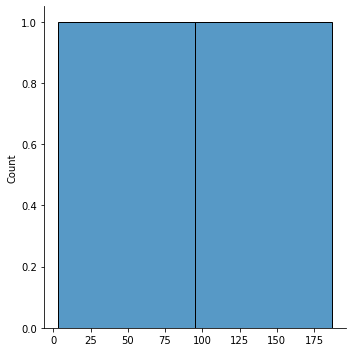

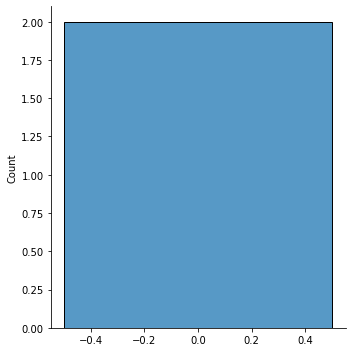

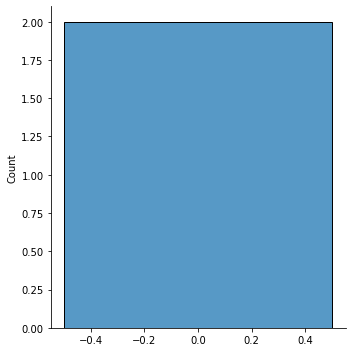

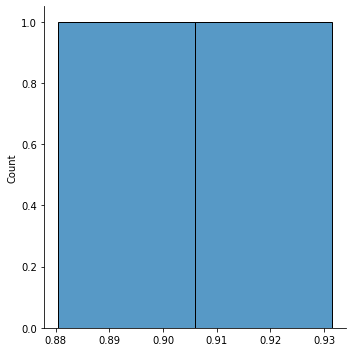

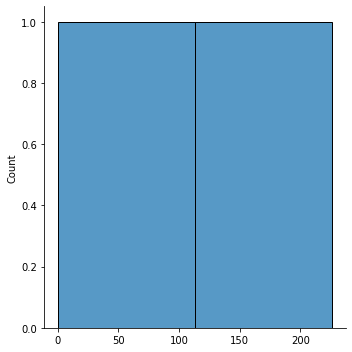

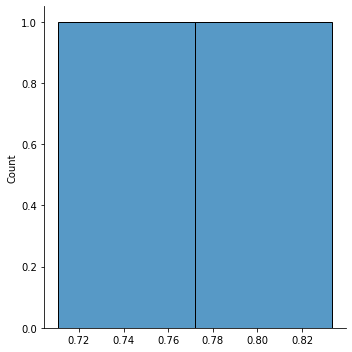

In [15]:

import seaborn as sb
stat = {
        'successed': [],
        'query': [],
        'pll': [],
        'I': [],
        'use': [],
        'bpstep': [],
        'token_acc': [],
    }
for key in stat.keys():
    for data in alla:
        stat[key].append(data[key])
    sb.displot(stat[key])
    if key != 'successed':
        stat[key] = np.array(stat[key]).mean()
    else:
        stat[key] = len(suca)/len(alla)
print(stat)

In [16]:
u = []
bar = 0
alla = torch.load('alla2.pt')
for data in alla:
    u.append(data['use'])
u.sort()
u = np.array(u)
print(u[bar:].mean())
print(len(u[bar:]) / len(u))

FileNotFoundError: [Errno 2] No such file or directory: 'alla2.pt'

In [ ]:
print(u)

In [ ]:
len(suca)/len(alla)

In [ ]:
for data in alla:
    if data['use'] > 0.85:
        print(data)

In [ ]:
len(alla)

In [ ]:
100/102